# Bootstrap

In the attached Excel file you can find data from European money and swap markets for spot date October 3, 2012. Daycount convention is actual/360. Euro denominated swaps have annual paying fixed leg.

Build the discount curve using the bootstrap method explained in the lecture. Report the simple forward rate over the future period October 4, 2041 to October 3, 2042. Express your answer in percentage points and round to 2 decimal places.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

In [2]:
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

In [3]:
s = date(2012, 10, 3) # spot date

data = """2012/10/4	0.095	LIBOR
2012/11/5	0.116	LIBOR
2013/1/3	0.223	LIBOR
2013/4/3	0.438	LIBOR
2013/6/19	99.786	Futures
2013/9/18	99.752	Futures
2013/12/18	99.723	Futures
2014/3/19	99.669	Futures
2014/10/3	0.475	Swap
2015/10/5	0.586	Swap
2016/10/3	0.752	Swap
2017/10/3	0.942	Swap
2019/10/3	1.324	Swap
2022/10/3	1.739	Swap
2027/10/4	2.165	Swap
2032/10/4	2.280	Swap
2042/10/3	2.332	Swap
"""
LIBOR_data = pd.Series(dtype='float')
Futures_data = pd.Series(dtype='float')
Swap_data = pd.Series(dtype='float')

for line in data.splitlines():
    t, quote, type_ = line.split('\t')
    t = datetime.strptime(t, "%Y/%m/%d").date()
    quote = float(quote)
    if type_ == 'LIBOR':
        simple_rate = quote / 100
        LIBOR_data[t] = simple_rate
    elif type_ == 'Futures':
        futures_rate = (100 - quote) / 100
        Futures_data[t] = futures_rate
    elif type_ == 'Swap':
        swap_rate = quote / 100
        Swap_data[t] = swap_rate

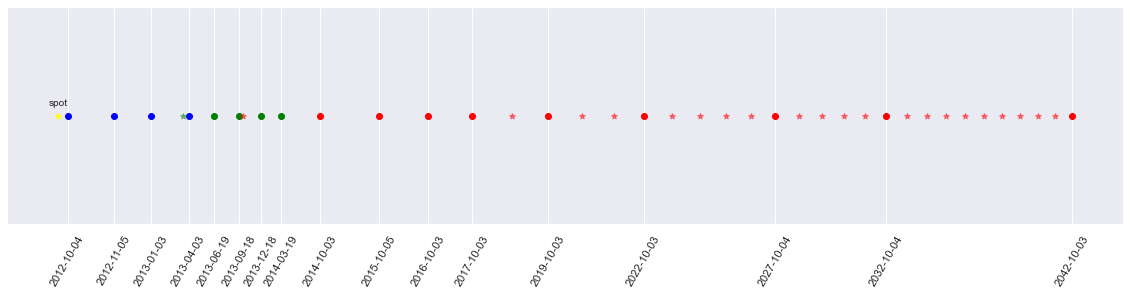

In [4]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)
ax.get_yaxis().set_visible(False)


def Show_Time_Data(ax, *time_lists):
    xticks = []
    xticklabels = []
    i = -1
    colors = ['blue', 'green', 'red']
    for time_list in time_lists:
        i += 1
        dt = [np.sqrt((t - s).days) for t in time_list]
        y = np.zeros(len(dt))
        ax.scatter(x=dt, y=y, c=colors[i])
        xticks += dt
        xticklabels += list(time_list)
        if i == 1: # futures
            tmp = time_list[0] - relativedelta(months=3)
            ax.scatter(x=np.sqrt((tmp - s).days), y=0, color=colors[i], alpha=0.5, marker='*')
        if i == 2: # swaps
            tmp = time_list[0] - relativedelta(years=1)
            while tmp.year < 2042:
                ax.scatter(x=np.sqrt((tmp - s).days), y=0, color=colors[i], alpha=0.5, marker='*')
                tmp = tmp + relativedelta(years=1)
                
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=60)
    ax.scatter(x=0, y=0, color='yellow', marker='*') # spot date
    ax.annotate('spot', xy=(0,0), xytext=(-1,0.005))
    
Show_Time_Data(ax, LIBOR_data.keys().values, Futures_data.keys().values, Swap_data.keys().values)

In [5]:
discounted_price_bootstrap = pd.Series(dtype='float')
simple_rate_bootstrap = pd.Series(dtype='float')

In [6]:
LIBOR_data

2012-10-04    0.00095
2012-11-05    0.00116
2013-01-03    0.00223
2013-04-03    0.00438
dtype: float64

In [7]:
def Interpolate(t, t1, v1, t2, v2):
    dt1 = (t - t1).days
    dt2 = (t2 - t).days
    w1 = dt2 / (dt1 + dt2)
    w2 = dt1 / (dt1 + dt2)
    v = w1 * v1 + w2 * v2
    return v

def Find_Interpolation_Place(lst, target):
    lst = sorted(lst)
    i = 0
    while i < len(lst) and target > lst[i]:
        i += 1
    if i == len(lst):
        return lst[-2], lst[-1]
    if i == 0:
        return lst[0], lst[1]
    return lst[i - 1], lst[i]

In [8]:
# (1) LIRBOR

for t, simple_rate in LIBOR_data.items():
    dt = (t - s).days / 360
    price = 1 / (1 + simple_rate * dt)
    discounted_price_bootstrap[t] = price
    simple_rate_bootstrap[t] = simple_rate

# (2) Futures

# --- use the last two LIBOR rates to interpolate
# --- (last two blue -> star green)
t_futures_star = Futures_data.index[0] - relativedelta(months=3)
simple_rate_futures_star = Interpolate(t=t_futures_star, t1=LIBOR_data.index[-2], v1=LIBOR_data.iloc[-2], t2=LIBOR_data.index[-1], v2=LIBOR_data.iloc[-1])
price_futures_star = 1 / (1 + simple_rate_futures_star * (t_futures_star - s).days / 360)
discounted_price_bootstrap[t_futures_star] = price_futures_star
simple_rate_bootstrap[t_futures_star] = simple_rate_futures_star

# --- use futures as proxy for forward rate
last_t = t_futures_star
last_price = price_futures_star
for t, futures_rate in Futures_data.items():
    dt = (t - last_t).days / 360
    price = last_price / (1 + futures_rate * dt)
    simple_rate =  (1 / price - 1) / ((t - s).days / 360)
    # update
    discounted_price_bootstrap[t] = price
    simple_rate_bootstrap[t] = simple_rate
    last_t = t
    last_price = price
    

# (3) Swap
# --- use the nearest two simple rates (futures) to interpolate
# --- nearest two green -> star red
# --- star red: first swap contract, only pay once => swap rate = simple rate
t_swap_star = Swap_data.index[0] - relativedelta(years=1)
t1, t2 = Find_Interpolation_Place(simple_rate_bootstrap.index.values, t_swap_star)
simple_rate_swap_star = Interpolate(t=t_swap_star, t1=t1, v1=simple_rate_bootstrap[t1], t2=t2, v2=simple_rate_bootstrap[t2])
price_swap_star = 1 / (1 + simple_rate_swap_star * (t_swap_star - s). days / 360) # discounted bond price at red star
discounted_price_bootstrap[t_swap_star] = price_swap_star
simple_rate_bootstrap[t_swap_star] = simple_rate_swap_star


simple_rate_bootstrap = simple_rate_bootstrap.sort_index()
discounted_price_bootstrap = discounted_price_bootstrap.sort_index()

# swap rate interpolation
swap_dates= Swap_data.index.values
swap_rates = pd.Series(dtype='float')
swap_rates[t_swap_star] = simple_rate_swap_star
for i in range(len(swap_dates)):
    t = swap_dates[i]
    swap_rates[t] = Swap_data[t]
    if i == len(swap_dates) - 1:
        break
    if swap_dates[i + 1].year > t.year + 1:
        for dy in range(1, swap_dates[i + 1].year - t.year): # delta year
            tmp = date(t.year + dy, t.month, t.day)
            swap_rate = Interpolate(t=tmp, t1=t, v1=Swap_data[t], t2=swap_dates[i + 1], v2=Swap_data[swap_dates[i + 1]])
            swap_rates[tmp] = swap_rate

dt_list = [(t_swap_star - s).days / 360]
P_list = [price_swap_star]
for i in range(1, len(swap_rates)):
    t = swap_rates.index[i]
    swap_rate = swap_rates[t]
    last_t = swap_rates.index[i - 1]
    dt = (t - last_t).days / 360
    price = (1  - swap_rate * (np.array(dt_list) @ np.array(P_list))) / (1 + swap_rate * dt)
    dt_list.append(dt)
    P_list.append(price)
    # update
    discounted_price_bootstrap[t] = price
    simple_rate_bootstrap[t] = (1 / price - 1) / ((t - s).days / 360)

In [9]:
discounted_price_bootstrap

2012-10-04    0.999997
2012-11-05    0.999894
2013-01-03    0.999430
2013-03-19    0.998138
2013-04-03    0.997791
2013-06-19    0.997592
2013-09-18    0.996967
2013-10-03    0.996850
2013-12-18    0.996270
2014-03-19    0.995437
2014-10-03    0.990429
2015-10-05    0.982324
2016-10-03    0.969942
2017-10-03    0.953244
2018-10-03    0.933045
2019-10-03    0.909548
2020-10-03    0.886893
2021-10-03    0.862211
2022-10-03    0.835582
2023-10-03    0.812509
2024-10-03    0.788431
2025-10-03    0.763560
2026-10-03    0.737912
2027-10-04    0.711497
2028-10-04    0.693011
2029-10-04    0.674663
2030-10-04    0.656415
2031-10-04    0.638275
2032-10-04    0.620207
2033-10-04    0.605316
2034-10-04    0.590701
2035-10-04    0.576357
2036-10-04    0.562244
2037-10-04    0.548432
2038-10-04    0.534880
2039-10-04    0.521584
2040-10-04    0.508505
2041-10-04    0.495710
2042-10-03    0.483193
dtype: float64

## Question

Build the discount curve using the bootstrap method explained in the lecture. Report the simple forward rate over the future period October 4, 2041 to October 3, 2042. Express your answer in percentage points and round to 2 decimal places.



In [10]:
p1, p2 = discounted_price_bootstrap.values[-2], discounted_price_bootstrap[-1]
t1, t2 = discounted_price_bootstrap.index[-2], discounted_price_bootstrap.index[-1]
dt = (t2 - t1).days / 360
r = (p1 / p2 - 1) / dt
print(f"{r * 100:.3}")

2.56
